In [1]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q bfa71619dbb23c9417430926e4c426c9d2b969b4
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [1]:
from MI_prediction.Utils.Datasets import DataLoader, DataLoader_Rest, get_epochs, get_runs, get_labels
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from MI_prediction.Utils.Preprocess import filterbank_preprocessor, filterbank,FBCSP
from MI_prediction.Validation.Scores import get_scores_cv, get_scores
from MI_prediction.Utils.Windowers import create_windows
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from mne.preprocessing import compute_current_source_density

import time
import pickle

# Lawhern2018 sklearn

## BCI2a

### Load data

In [35]:
dl = DataLoader(dataset_name="BNCI2014001")
subjects = np.arange(1,10)

In [36]:
save_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/BCI2a/4Class/'

### Preprocessing

In [37]:
fb = filterbank_preprocessor([(8.,15.),(15.,25.)])

preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

st_offsets, ed_offsets = create_windows(win = 1.5, start_offset = -2, end_offset = 1, mi_duration = 4, overlap = 0.5)


band to filter: (8.0, 15.0) Hz
band to filter: (15.0, 25.0) Hz


In [38]:
experiment_name = 'FB_8-15_15-25_WN_15_OV_05'

acc = {}

for s in subjects:
    print ("Subject: {}".format(s))
    tic = time.time()

    dl.load_data(subject_ids=[s])
    ds_f = filterbank(dl, preprocess=preprocessors, filters=fb, channels_prep=[])
    trials = [tr.get_trials(start_offset=st_offsets, end_offset=ed_offsets) for tr in ds_f]

    acc[str(s)] = {}

    for nw in range(len(st_offsets)):
        epochs = [get_epochs(epoch['win_'+str(nw)].split('session')['session_T']) for epoch in trials]
        
        X = np.concatenate([np.expand_dims(trial[0],axis=3) for trial in epochs], axis=-1,dtype=np.float64)
        y = epochs[0][1]

        #X, y = get_labels(X,y,[0,1]) # for 2 classes

        skf = StratifiedKFold(n_splits=4)

        fbcsp = FBCSP(norm_trace=False)
        lda = LinearDiscriminantAnalysis()

        param_grid = {
                'fbcsp__n_components': [4,6,8]
                }

        clf = Pipeline([('fbcsp', fbcsp), ('lda', lda)])
        cvs = GridSearchCV(clf,param_grid=param_grid,cv=skf,scoring='accuracy',n_jobs=1, verbose=1)
        cvs.fit(X,y)

        mu, sig = get_scores_cv(cvs)
        mdl = cvs.best_estimator_
        mdl.fit(X,y)

        epochs_ts = [get_epochs(epoch['win_'+str(nw)].split('session')['session_E']) for epoch in trials]
        
        X_test = np.concatenate([np.expand_dims(trial[0],axis=3) for trial in epochs_ts], axis=-1,dtype=np.float64)
        y_test = epochs_ts[0][1]

        #X_test, y_test = get_labels(X_test,y_test,[0,1]) # for 2 classes

        ypred = mdl.predict(X_test)
        acc_ts = accuracy_score(y_test,ypred)

        acc[str(s)]['win_'+str(nw)]={
                'acc_train': mu,
                'std_train': sig,
                'acc_test': acc_ts,
                'model': mdl
                }
        
        print("Accuracy train: {}  Accuracy test: {}  elapsed: {}".format(mu,acc_ts, time.time()-tic))

        pickle.dump(acc, open(save_path+experiment_name+'.pkl', 'wb'))

Subject: 1
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samp

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Fi

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff f

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge:

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 

### FB: (8,15) (15,25) WN: 0.5 OV: 0.5

In [6]:
experiment_name = 'FB_8-15_15-25_WN_05_OV_05'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [7]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [8]:
acc

,subject,window,accuracy,std
0,1,win_0,0.493056,0.056843
1,1,win_1,0.479167,0.086458
2,1,win_2,0.555556,0.051967
3,1,win_3,0.500000,0.092128
4,1,win_4,0.548611,0.079483
...,...,...,...,...
238,9,win_22,0.618056,0.030270
239,9,win_23,0.506944,0.045538
240,9,win_24,0.597222,0.108476
241,9,win_25,0.611111,0.058926


### FB: (8,15) (15,25) WN: 1 OV: 0.5

In [39]:
experiment_name = 'FB_8-15_15-25_WN_1_OV_05'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/BCI2a/4Class/FB_8-15_15-25_WN_1_OV_05.pkl'

In [101]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [102]:
acc

,subject,window,accuracy,std
0,1,win_0,0.611111,0.065145
1,1,win_1,0.479167,0.066246
2,1,win_2,0.444444,0.051967
3,1,win_3,0.534722,0.069096
4,1,win_4,0.666667,0.112834
...,...,...,...,...
112,9,win_8,0.756944,0.074471
113,9,win_9,0.631944,0.100874
114,9,win_10,0.597222,0.063647
115,9,win_11,0.541667,0.072169


### FB: (8,15) (15,25) WN: 1.5 OV: 0.5

In [40]:
experiment_name = 'FB_8-15_15-25_WN_15_OV_05'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [41]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [42]:
acc

,subject,window,accuracy,std
0,1,win_0,0.270833,0.060937
1,1,win_1,0.274306,0.033123
2,1,win_2,0.440972,0.045405
3,1,win_3,0.715278,0.028633
4,1,win_4,0.708333,0.074794
...,...,...,...,...
67,9,win_3,0.666667,0.089473
68,9,win_4,0.635417,0.070393
69,9,win_5,0.406250,0.026671
70,9,win_6,0.357639,0.024797


### FB: (8,15) (15,25) WN: 2 OV: 0.5

In [27]:
experiment_name = 'FB_8-15_15-25_WN_2_OV_05'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [28]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [29]:
acc

,subject,window,accuracy,std
0,1,win_0,0.298611,0.039893
1,1,win_1,0.329861,0.060040
2,1,win_2,0.718750,0.053228
3,1,win_3,0.774306,0.063930
4,1,win_4,0.677083,0.040937
5,1,win_5,0.486111,0.072169
6,2,win_0,0.239583,0.039741
7,2,win_1,0.267361,0.039741
8,2,win_2,0.416667,0.077951
9,2,win_3,0.552083,0.093363


### FB: (8,15) (15,25) WN: 4 OV: 0

In [19]:
experiment_name = 'FB_8-15_15-25_WN_4_OV_0'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [20]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [21]:
acc

,subject,window,accuracy,std
0,1,win_0,0.767361,0.024797
1,2,win_0,0.597222,0.068041
2,3,win_0,0.711806,0.090211
3,4,win_0,0.423611,0.082461
4,5,win_0,0.416667,0.072169
5,6,win_0,0.489583,0.091801
6,7,win_0,0.802083,0.069009
7,8,win_0,0.795139,0.088047
8,9,win_0,0.597222,0.058101


In [45]:
acc_ts

,subject,window,accuracy,std
0,1,win_0,0.965278,None
1,2,win_0,0.819444,None
2,3,win_0,0.888889,None
3,4,win_0,0.791667,None
4,5,win_0,0.604167,None
5,6,win_0,0.784722,None
6,7,win_0,0.798611,None
7,8,win_0,0.791667,None
8,9,win_0,0.854167,None


[]

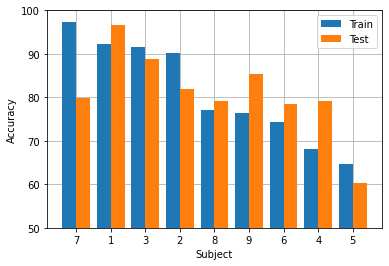

In [48]:
idx = np.argsort(acc['accuracy'])[::-1]
plt.bar(acc['subject']-0.2,acc['accuracy'][idx]*100,width=0.4,label='Train')
plt.bar(acc_ts['subject']+0.2,acc_ts['accuracy'][idx]*100,width=0.4,label='Test')
plt.xticks(acc['subject'],acc['subject'][idx])
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.ylim([50,100])
plt.grid(True)
ax = plt.gca()
ax.set_axisbelow(True) 
plt.plot()

In [17]:
acc

{'1': 0.9236111111111112,
 '2': 0.923611111111111,
 '3': 0.9791666666666666,
 '4': 0.6319444444444444,
 '5': 0.6458333333333334,
 '6': 0.7291666666666667,
 '7': 0.9652777777777779,
 '8': 0.7777777777777779,
 '9': 0.7638888888888888}

In [51]:
acc #(8,12) (12,38)

{'1': 0.923611111111111,
 '2': 0.9166666666666666,
 '3': 0.923611111111111,
 '4': 0.736111111111111,
 '5': 0.6388888888888888,
 '6': 0.7291666666666666,
 '7': 0.9722222222222223,
 '8': 0.7847222222222221,
 '9': 0.763888888888889}

In [42]:
acc # Con laplaciano

{'1': 0.9027777777777778,
 '2': 0.9097222222222222,
 '3': 0.9305555555555556,
 '4': 0.6805555555555556,
 '5': 0.5416666666666666,
 '6': 0.6388888888888888,
 '7': 0.9513888888888888,
 '8': 0.8680555555555556,
 '9': 0.7083333333333333}

In [39]:
acc # sin laplaciano

{'1': 0.9097222222222222,
 '2': 0.8958333333333334,
 '3': 0.9444444444444444,
 '4': 0.7013888888888888,
 '5': 0.5277777777777778,
 '6': 0.6319444444444444,
 '7': 0.9444444444444444,
 '8': 0.8680555555555556,
 '9': 0.7569444444444444}